In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd

df_latih = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pengembangan_ML/Corona_NLP_train.csv',encoding='latin-1')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pengembangan_ML/Corona_NLP_test.csv',encoding='latin-1')

df_latih

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [ ]:
df_latih = df_latih.drop(columns=['UserName','ScreenName','Location','TweetAt'])
df_test = df_test.drop(columns=['UserName','ScreenName','Location','TweetAt'])

In [ ]:
df_latih['OriginalTweet']

0        @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1        advice Talk to your neighbours family to excha...
2        Coronavirus Australia: Woolworths to give elde...
3        My food stock is not the only one which is emp...
4        Me, ready to go at supermarket during the #COV...
                               ...                        
41152    Airline pilots offering to stock supermarket s...
41153    Response to complaint not provided citing COVI...
41154    You know itÂs getting tough when @KameronWild...
41155    Is it wrong that the smell of hand sanitizer i...
41156    @TartiiCat Well new/used Rift S are going for ...
Name: OriginalTweet, Length: 41157, dtype: object

In [ ]:
sentiment_latih = pd.get_dummies(df_latih.Sentiment)
sentiment_test = pd.get_dummies(df_test.Sentiment)

In [ ]:
new_df_latih = pd.concat([df_latih,sentiment_latih],axis=1)
new_df_latih = new_df_latih.drop(columns='Sentiment')


In [ ]:
new_df_test = pd.concat([df_test,sentiment_test],axis=1)
new_df_test = new_df_test.drop(columns='Sentiment')


In [ ]:
dataframe = pd.concat([new_df_test,new_df_latih]).drop_duplicates().reset_index(drop=True)

In [ ]:
# menyeleksi data agar menjadi bersih
import re

reg = re.compile("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z t])|(w+://S+)")
tweet = []
for i in dataframe["OriginalTweet"]:
  tweet.append(reg.sub(" ", i))
dataframe = pd.concat([dataframe, pd.DataFrame(tweet, columns=["CleanedTweet"])], axis=1, sort=False)

In [ ]:
dataframe.head()

,OriginalTweet,Extremely Negative,Extremely Positive,Negative,Neutral,Positive,CleanedTweet
0,TRENDING: New Yorkers encounter empty supermar...,1,0,0,0,0,TRENDING New Yorkers encounter empty supermar...
1,When I couldn't find hand sanitizer at Fred Me...,0,0,0,0,1,When I couldn t find hand sanitizer at Fred Me...
2,Find out how you can protect yourself and love...,0,1,0,0,0,Find out how you can protect yourself and love...
3,#Panic buying hits #NewYork City as anxious sh...,0,0,1,0,0,buying hits City as anxious shoppers stock...
4,#toiletpaper #dunnypaper #coronavirus #coronav...,0,0,0,1,0,19 One week everyone...


In [ ]:
dataframe = dataframe.drop(columns=['OriginalTweet'])

In [ ]:
dataframe.head()

,Extremely Negative,Extremely Positive,Negative,Neutral,Positive,CleanedTweet
0,1,0,0,0,0,TRENDING New Yorkers encounter empty supermar...
1,0,0,0,0,1,When I couldn t find hand sanitizer at Fred Me...
2,0,1,0,0,0,Find out how you can protect yourself and love...
3,0,0,1,0,0,buying hits City as anxious shoppers stock...
4,0,0,0,1,0,19 One week everyone...


In [ ]:
tweet = dataframe['CleanedTweet'].values
label = dataframe[['Extremely Negative','Positive','Extremely Positive','Negative','Neutral']].values

In [ ]:
from sklearn.model_selection import train_test_split
tweet_train,tweet_test,label_train,label_test = train_test_split(tweet,label,test_size=0.2)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(tweet_train)
tokenizer.fit_on_texts(tweet_test)

sequence_latih = tokenizer.texts_to_sequences(tweet_train)
sequence_test = tokenizer.texts_to_sequences(tweet_test)

padded_latih = pad_sequences(sequence_latih)
padded_test = pad_sequences(sequence_test)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.91):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(5000, 16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
num_epochs = 30
history = model.fit(padded_latih, label_train, epochs=num_epochs, 
                    validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/30
1124/1124 - 46s - loss: 1.2747 - accuracy: 0.4404 - val_loss: 0.8721 - val_accuracy: 0.6603 - 46s/epoch - 41ms/step
Epoch 2/30
1124/1124 - 43s - loss: 0.7008 - accuracy: 0.7474 - val_loss: 0.6847 - val_accuracy: 0.7586 - 43s/epoch - 38ms/step
Epoch 3/30
1124/1124 - 43s - loss: 0.5752 - accuracy: 0.8013 - val_loss: 0.6221 - val_accuracy: 0.7850 - 43s/epoch - 39ms/step
Epoch 4/30
1124/1124 - 43s - loss: 0.5143 - accuracy: 0.8234 - val_loss: 0.5910 - val_accuracy: 0.7925 - 43s/epoch - 38ms/step
Epoch 5/30
1124/1124 - 43s - loss: 0.4543 - accuracy: 0.8433 - val_loss: 0.6055 - val_accuracy: 0.7919 - 43s/epoch - 38ms/step
Epoch 6/30
1124/1124 - 42s - loss: 0.4088 - accuracy: 0.8577 - val_loss: 0.5993 - val_accuracy: 0.7912 - 42s/epoch - 38ms/step
Epoch 7/30
1124/1124 - 43s - loss: 0.3761 - accuracy: 0.8685 - val_loss: 0.6439 - val_accuracy: 0.7896 - 43s/epoch - 38ms/step
Epoch 8/30
1124/1124 - 42s - loss: 0.3443 - accuracy: 0.8799 - val_loss: 0.6765 - val_accuracy: 0.7865 - 42s/ep

In [ ]:
import matplotlib.pyplot as plt

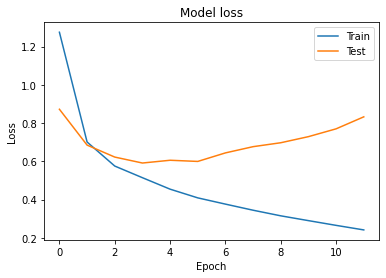

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper right')
plt.show()

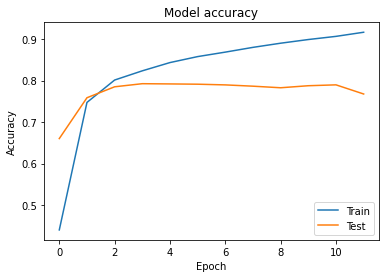

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='lower right')
plt.show()